In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
#%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.wcs import WCS
#from prompt_toolkit.input.win32 import Vt100ConsoleInputReader
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.integrate import simpson
import os
import pandas as pd

from DataManager import DataManager

In [18]:
#Consts
#ROOT = os.path.dirname(os.path.realpath(__file__))
ROOT = os.getcwd()
M81_Path = ROOT+'/data/M81/'
NGC2281_Path = ROOT+'/data/NGC2281/'
OUT_Path = ROOT+'/img/'
GAIN = 1.56

#Get Data
'''
Object Structure of return from DataManager.retrieve():
{'Flat_V': []
,'Flat_R': []
,'Flat_B': []
,'Light_V': []
,'Light_R': []
,'Light_B': []
,'Dark': []
,'Bias': []
}
'''
DM = DataManager()

DM.fetchData(NGC2281_Path)
NGC2281 = DM.retrieve()
DM.clear()

## Exposure Times of NGC2281

- **Light (v/r)**: 5 s
- **Light (b)**: 10 s
- **Dark**: 30 s
- **Bias**: 0 s
- **Flat (b)**: 4 s
- **Flat (r)**: 3.5 s
- **Flat (v)**: 4 s

In [19]:
# Defining the frames, aka here are all the masterframes for each of the pictures.
flat_v = NGC2281["Flat_V"]
flat_r = NGC2281["Flat_R"]
flat_b = NGC2281["Flat_B"]
light_v = NGC2281["Light_V"]
light_r = NGC2281["Light_R"]
light_b = NGC2281["Light_B"]
dark = NGC2281["Dark"]
bias = NGC2281["Bias"]
# exposure times:
exposure_time_dark = 30
exposure_time_flat_b = 4
exposure_time_flat_v = 4
exposure_time_flat_r = 3.5
exposure_time_light_b = 10
exposure_time_light_v = 5
exposure_time_light_r = 5

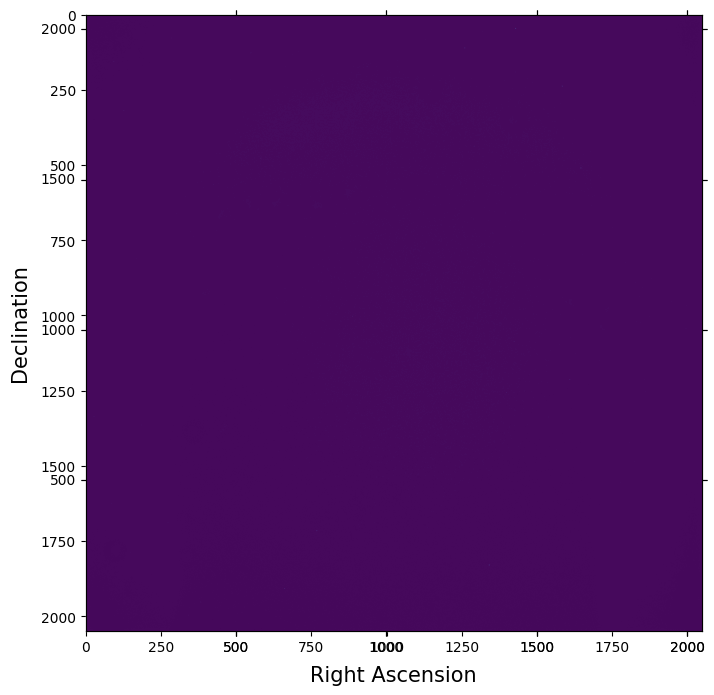

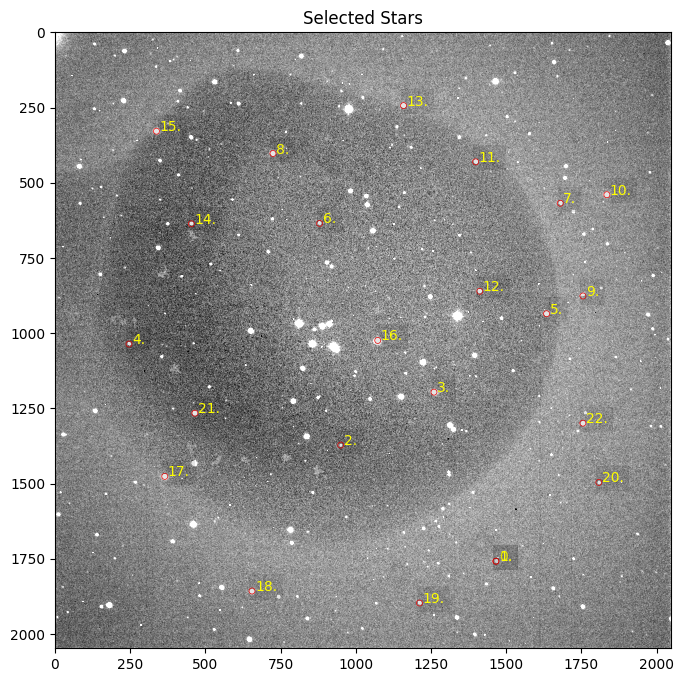

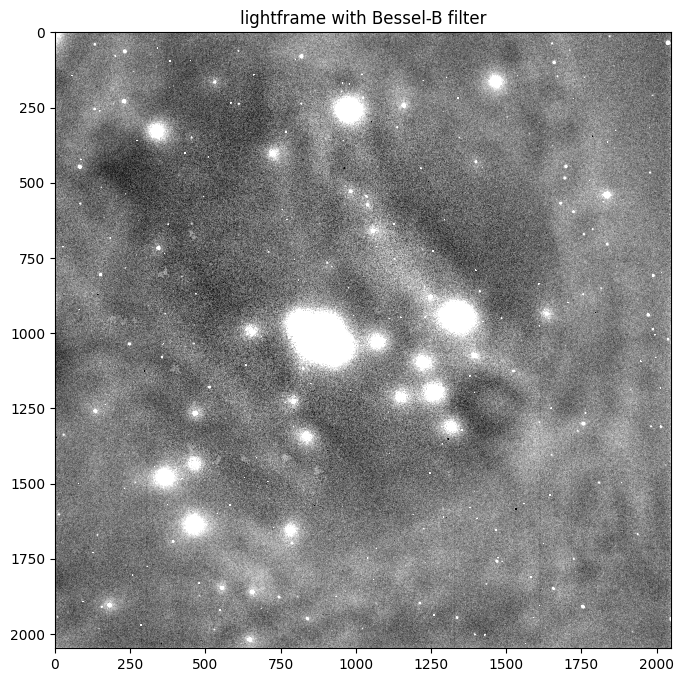

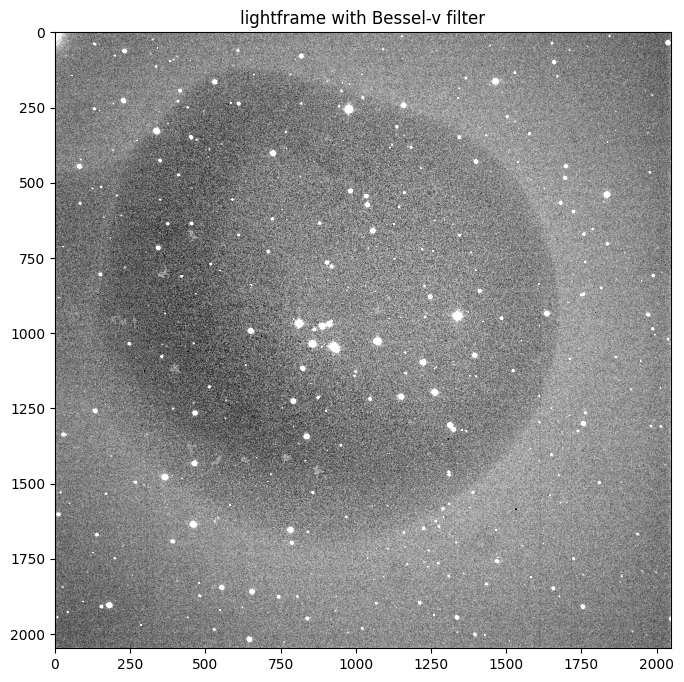

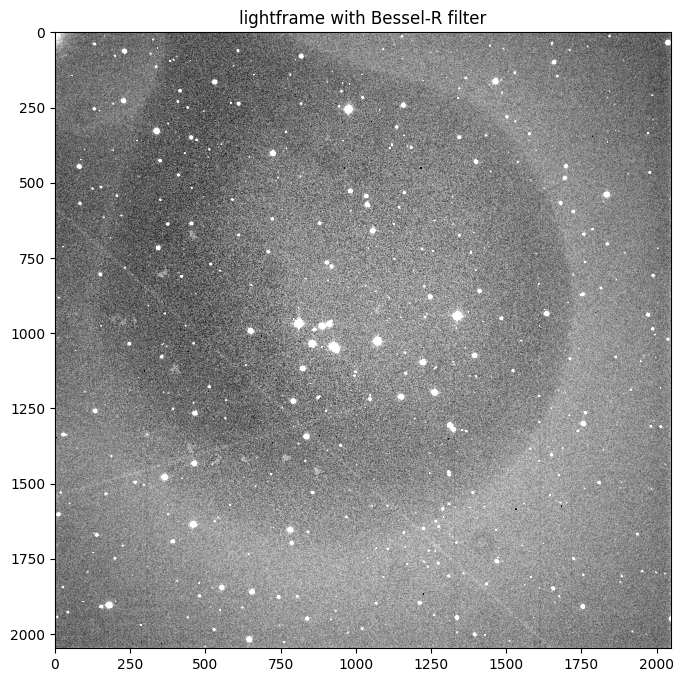

In [20]:
%matplotlib inline
# Correction of the scienceframes: TODO: Check how the exposure time should be done
# HEREEEEEEE I am doing the (hopefully) correct Data Reduction:

# first, remove the Bias from the Dark and scale the Dark down to 1 sek.:
master_dark_1_sek = (dark - bias) / exposure_time_dark

# now lets correct the flats for their respective filters and axposure times:
# for that, just multiply the down scaled dark y the respective exposure times,
# as a last step normalise the flat by dividing by the max(flat):

master_flat_b = ((flat_b - bias) - (master_dark_1_sek * exposure_time_flat_b))
master_flat_b = master_flat_b / np.max(master_flat_b)

master_flat_v = ((flat_v - bias) - (master_dark_1_sek * exposure_time_flat_v))
master_flat_v = master_flat_v / np.max(master_flat_v)

master_flat_r = ((flat_r - bias) - (master_dark_1_sek * exposure_time_flat_r))
master_flat_r = master_flat_r / np.max(master_flat_r)

# now pretty much the same for the light framse:

master_light_b = ((light_b - bias) - (master_dark_1_sek * exposure_time_light_b))
corrected_light_b = master_light_b / np.max(master_light_b)

master_light_v = ((light_v - bias) - (master_dark_1_sek * exposure_time_light_v))
corrected_light_v = master_light_v / np.max(master_light_v)

master_light_r = ((light_r - bias) - (master_dark_1_sek * exposure_time_light_r))
corrected_light_r = master_light_r / np.max(master_light_r)


# Plotting the three images:
fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-B filter")
plt.imshow(corrected_light_b, cmap = 'gray', vmin = np.percentile(corrected_light_b, 5), vmax = np.percentile(corrected_light_b, 95))
plt.show()

fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-v filter")
plt.imshow(corrected_light_v, cmap = 'gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.show()

fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-R filter")
plt.imshow(corrected_light_r, cmap = 'gray', vmin = np.percentile(corrected_light_r, 5), vmax = np.percentile(corrected_light_r, 95))
plt.show()
 


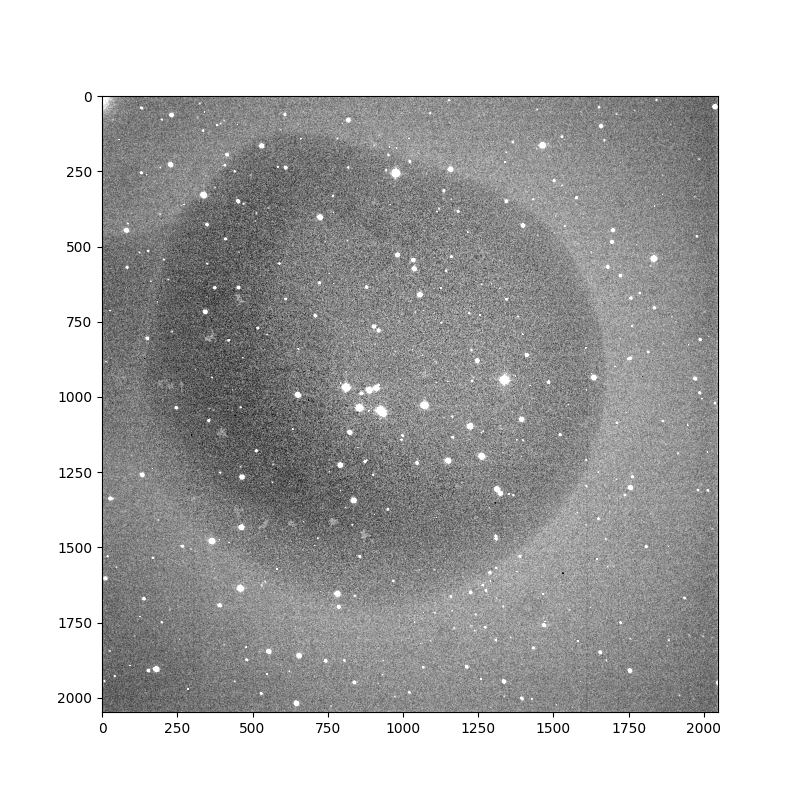

(2048, 2048) -0.03148527790439451 1.0


In [21]:
#%matplotlib notebook
%matplotlib widget
#%matplotlib inline
# This is needed to allow interactivity and showing the position of the mouse to find the stars.

fig = plt.figure(figsize=(8,8))
plt.imshow(corrected_light_v, cmap = 'gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.show()
print(corrected_light_v.shape, np.min(corrected_light_v), np.max(corrected_light_v))

Filename: d:\Julian\Documents\UNI\astro\Praktikum\AstroPrak\Nordkuppel/data/NGC2281/0001_Flat_V.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (2048, 2048)   uint16   
SIMPLE  =                    T                                                  BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 2048 /fastest changing axis                           NAXIS2  =                 2048 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2025-03-21T18:13:51' /YYYY-MM-DDThh:mm:ss observation start, UT      EXPTIME =   4.0000000000000000 /Exposure time in seconds                        EXPOSURE=   4.0000000000000000 /Exposure time in s

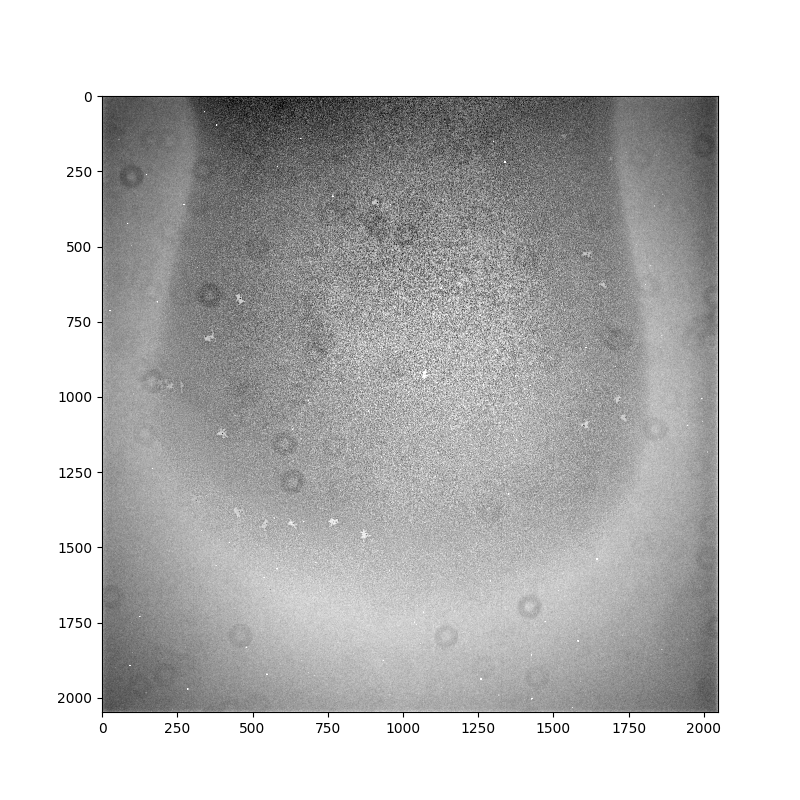

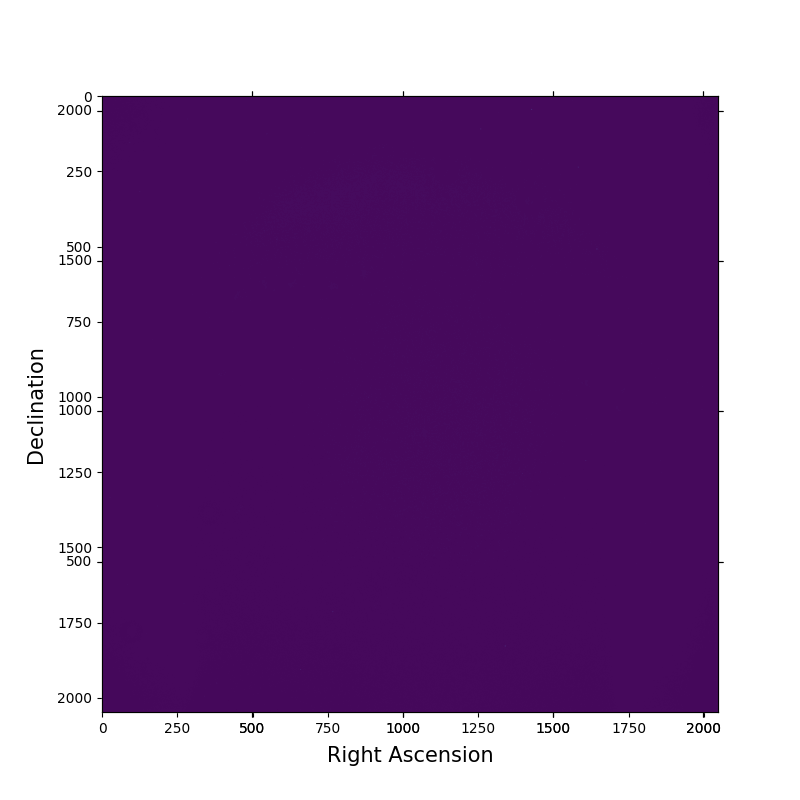

In [22]:
with fits.open(f'{NGC2281_Path}0001_Flat_V.fits') as file:
    header = file[0].header
    data = file[0].data
    n_axis = file[0].header["NAXIS"]
    file.info()

print(header)
print("--------------------------------------")
print(data)
print("--------------------------------------")
print(f"How many axes: {n_axis}")
print("--------------------------------------")
print(f' Number of objects in NAXIS1: {header["NAXIS1"]} \n')
print(f' Number of objects in NAXIS2: {header["NAXIS2"]} \n')



print(f"data[0] and len(): {data[0]}, {len(data[0])} \n")
print(f"data[1] and len(): {data[1]}, {len(data[1])} \n")
print(len(data))
#data ist eine Matrix mit 1365 reihen in diesen sind jeweils 1365 werte drinnen


plt.imshow(data, cmap='gray', vmin = np.percentile(data, 5), vmax = np.percentile(data, 95))
plt.show()

wcs = WCS(header)

plt.subplot(projection=wcs)
plt.imshow(data, origin='lower')
plt.grid(True)
plt.xlabel('Right Ascension', size=15)
plt.ylabel('Declination', size=15)
plt.xticks(fontsize=18) # sets the size of the numbers on the axis
plt.yticks(fontsize=18)
plt.savefig(OUT_Path+"image_with_wcs.svg", bbox_inches = "tight") # bbox tight removes as much white space as possible
plt.show()
# für RGB bild numpy.destack
# schaun dass bilder azwischen 0 und 1 normier sind
# 

In [26]:

# 1. Stunden, Minuten, Sekunden -> Sekunden insgesamt
def hms_to_seconds(hour, minute, second):
    return hour * 3600 + minute * 60 + second

# 2. Sekunden -> Stunden, Minuten, Sekunden
def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    sec = seconds % 60
    return hours, minutes, sec

# 3. Grad, Bogenminuten, Bogensekunden -> Bogensekunden insgesamt
def dms_to_arcseconds(degrees, arcminutes, arcseconds):
    return degrees * 3600 + arcminutes * 60 + arcseconds

# 4. Bogensekunden -> Grad, Bogenminuten, Bogensekunden
def arcseconds_to_dms(arcseconds):
    degrees = arcseconds // 3600
    arcminutes = (arcseconds % 3600) // 60
    sec = arcseconds % 60
    return degrees, arcminutes, sec

# alle referenzsternen pixel werte star(X,Y), 1bis5 von Philipp, 6bis9 von Elias
reference_star_1_pix = (1466, 1758)
reference_star_2_pix = (392, 1691)
reference_star_3_pix = (950, 1372)
reference_star_4_pix = (1260, 1196)
reference_star_5_pix = (246, 1036)
reference_star_6_pix = (int(np.mean([1626.8, 1641.7])), int(np.mean([942.3, 928.4])))
reference_star_7_pix = (int(np.mean([876.58, 883.14])), int(np.mean([637.87, 631.86])))
reference_star_8_pix = (int(np.mean([1675.69, 1684.49])), int(np.mean([573.26, 562.85])))
reference_star_9_pix = (int(np.mean([717.6, 731.9])), int(np.mean([409.0, 396.0])))

# alle referenzterne sky coordinate werte:
# originalerweise RA [hh:mm:ss]stunden, DEC [dd:mm:ss]degree
# neue version: RA [seconds], DEC [arcseconds]
reference_star_1_coord = (hms_to_seconds(6, 48, 48.52), dms_to_arcseconds(41, 11, 28.4))
reference_star_2_coord = (hms_to_seconds(6, 47, 55.57), dms_to_arcseconds(41, 11, 10.0))
reference_star_3_coord = (hms_to_seconds(6, 48, 22.51), dms_to_arcseconds(41, 8, 3.9))
reference_star_4_coord = (hms_to_seconds(6, 48, 37.54), dms_to_arcseconds(41, 6, 21.1))
reference_star_5_coord = (hms_to_seconds(6, 47, 47.56), dms_to_arcseconds(41, 5, 8.7))
reference_star_6_coord = (hms_to_seconds(6, 48, 55.36), dms_to_arcseconds(41, 3, 49.3))
reference_star_7_coord = (hms_to_seconds(6, 48, 17.94), dms_to_arcseconds(41, 1, 15.9))
reference_star_8_coord = (hms_to_seconds(6, 48, 57.06), dms_to_arcseconds(41, 0, 25.1))
reference_star_9_coord = (hms_to_seconds(6, 48, 10.05), dms_to_arcseconds(40, 59, 10.1))

# alle neuen sterne in Pixelwerten (X,Y): 1bis7 von Elias, 8bis14 von Philipp
new_star_1_pix = (int(np.mean([1751.46, 1759.07])), int(np.mean([875.53, 876.92])))
new_star_2_pix = (int(np.mean([1825.6, 1844.0])), int(np.mean([548.1, 530.9])))
new_star_3_pix = (int(np.mean([1393.1, 1404.0])), int(np.mean([435.7, 424.9])))
new_star_4_pix = (int(np.mean([1407.7, 1417.09])), int(np.mean([864.95, 856.15])))
new_star_5_pix = (int(np.mean([1152.68, 1164.98])), int(np.mean([249.38, 237.18])))
new_star_6_pix = (int(np.mean([449.66, 457.14])), int(np.mean([640.46, 632.23])))
new_star_7_pix = (int(np.mean([329.2, 345.6])), int(np.mean([337.8, 318.8])))
new_star_8_pix = (1073, 1024)
new_star_9_pix = (365, 1476)
new_star_10_pix = (655, 1857)
new_star_11_pix = (1212, 1897)
new_star_12_pix = (1808, 1496)
new_star_13_pix = (465, 1266)
new_star_14_pix = (1755, 1299)

print(reference_star_1_pix)
#print(reference_star_7_pix)
#print(reference_star_8_pix)
#print(reference_star_9_pix)
print(reference_star_1_coord)
#print(reference_star_7_coord)
#print(reference_star_8_coord)
#print(reference_star_9_pix)
#print(reference_star_9_coord)


print("<=========================================>")
print(arcseconds_to_dms(reference_star_6_coord[1]))

(1466, 1758)
(24528.52, 148288.4)
<=========================================>
(41.0, 3.0, 49.29999999998836)


C:\Users\Julian\AppData\Local\Temp\ipykernel_6300\1080672754.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))


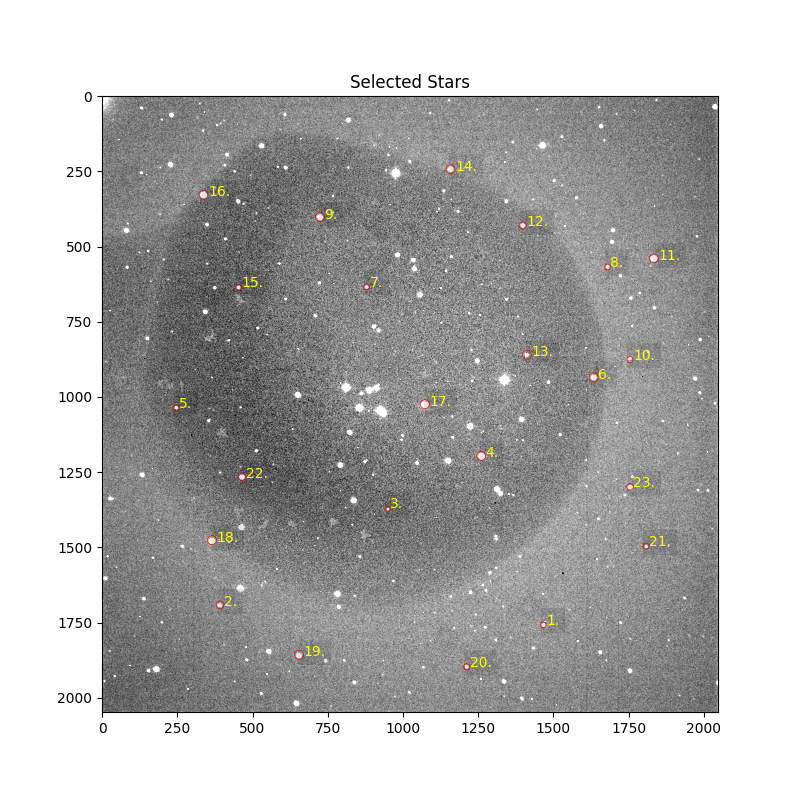

[0.31740981 0.42152587 0.13265452 1.89495841 0.22714964 0.88278252
 0.22895081 0.25564957 1.09694848 0.22687502 1.42656504 0.43572925
 0.54718869 0.76775157 0.25427575 1.84961255 2.93494277 1.70610198
 0.80611904 0.24114285 0.21356627 0.76807523 0.48199496]


In [44]:
#Circle midpoints (x, y) from reference stars
stars = [
    reference_star_1_pix
    ,reference_star_2_pix
    ,reference_star_3_pix
    ,reference_star_4_pix
    ,reference_star_5_pix
    ,reference_star_6_pix
    ,reference_star_7_pix
    ,reference_star_8_pix
    ,reference_star_9_pix
    #--------------------
    ,new_star_1_pix
    ,new_star_2_pix
    ,new_star_3_pix
    ,new_star_4_pix
    ,new_star_5_pix
    ,new_star_6_pix
    ,new_star_7_pix
    ,new_star_8_pix
    ,new_star_9_pix
    ,new_star_10_pix
    ,new_star_11_pix
    ,new_star_12_pix
    ,new_star_13_pix
    ,new_star_14_pix
]

#Circle sizes
radii = [
    10
    ,13
    ,8
    ,15
    ,10
    ,15
    ,10
    ,10
    ,15
    #-----
    ,10
    ,15
    ,12
    ,15
    ,15
    ,10
    ,15
    ,15
    ,15
    ,15
    ,10
    ,10
    ,12
    ,11
]

#Visualization
def plot_marked_stars(image, centers, radii):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap = 'gray', vmin = np.percentile(image, 5), vmax = np.percentile(image, 95))
    
    # Overlay circular patches
    for i, (center, radius) in enumerate(zip(centers, radii)):
        circle = Circle(center, radius, color='red', fill=False, linewidth=0.5)
        ax.add_patch(circle)
        ax.text(center[0]+radius, center[1]+radius, f"{i+1}.", color='yellow', fontsize=10, ha='left', va='bottom', 
                bbox=dict(facecolor='black', alpha=0.1, edgecolor='none'))
    
    ax.set_title("Selected Stars")
    plt.show()




plot_marked_stars(corrected_light_v, stars, radii)

fluxes = DM.circularSelection(corrected_light_v, stars, radii)

fluxes_Corrected = np.divide(np.multiply(fluxes, GAIN), exposure_time_light_v)
print(fluxes_Corrected)

